# Canonicalizing Networks

In this project we shall be trying to establish canonicalization of networks to establish equivalence class of neural networks. We shall be extending this work to deep neural networks (including convolutional networks) in later stage of the project. 

Datasets: CIFAR10; when we extend this to deep networks we will look at the possibility of using the ImageNet dataset.

Method:
1. Split the **traindata** into **three** parts (for now we show only on three networks, will extend to more networks).
2. Build the three networks using same hyperparameters. 
3. **Fix** the first network. Let us call this as, network *A*. 
4. We modify the other two networks so that they look as close to *A* as possible. Validate that the alterations have been consistent throughout the network such that the networks are giving the same outputs.
5. Now combine networks *B* and *C* using $\alpha$ and $(1-\alpha)$ and create a new network. Investigate on its performance. (**done till here**)
6. Establish a **distance kernel** *K*. Use *k* to tell if two networks can be equal. $\texttt{Try to use graph kernels here}$.

Network type (architectures):
1. Begin with a simple two layer network (can extend to *n* layers, including *convolution* layers).
2. $\texttt{fc $\times$ ReLU $\times$ BN $\times$ Drop_out $\times$ fc $\times$ softmax}$
3. $\texttt{fc $\times$ ReLU $\times$ Drop_out $\times$ fc $\times$ softmax}$

# Setting up stuff

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from src.classifiers.fc_net import *
from src.data_utils import get_CIFAR10_data
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.solver import Solver
from src.canonicalize import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


In [3]:
# splitting up the train data

X_train = data['X_train']
y_train = data['y_train']

total_train_size = X_train.shape[0]
full_indices = np.random.permutation(total_train_size)

mask1 = range(total_train_size/3)
X_train1 = X_train[full_indices[mask1]]
y_train1 = y_train[full_indices[mask1]]

mask2 = range(total_train_size/3, 2*total_train_size/3)
X_train2 = X_train[full_indices[mask2]]
y_train2 = y_train[full_indices[mask2]]

mask3 = range(2*total_train_size/3, 3*total_train_size/3)
X_train3 = X_train[full_indices[mask3]]
y_train3 = y_train[full_indices[mask3]]

data1 = {
        'X_train': X_train1, 'y_train' : y_train1,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }
data2 = {
        'X_train': X_train2, 'y_train' : y_train2,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }
data3 = {
        'X_train': X_train3, 'y_train' : y_train3,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }

# Solver1

Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [4]:
best_model1 = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
# here I use the same parameters I got before, seems like they perform moderately fine
model1 = FullyConnectedNet([100, 100], weight_scale=0.0025, use_batchnorm = False, dropout = 0)
solver1 = Solver(model1, data1,
                        print_every=data1['X_train'].shape[0], num_epochs=5, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': 0.03,
                        },verbose=True, 
                 )
solver1.train()
best_model1 = model1
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 3265) loss: 2.307440
(Epoch 0 / 5) train acc: 0.152000; val_acc: 0.134000
(Epoch 1 / 5) train acc: 0.443000; val_acc: 0.421000
(Epoch 2 / 5) train acc: 0.490000; val_acc: 0.437000
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.458000
(Epoch 4 / 5) train acc: 0.519000; val_acc: 0.473000
(Epoch 5 / 5) train acc: 0.564000; val_acc: 0.479000


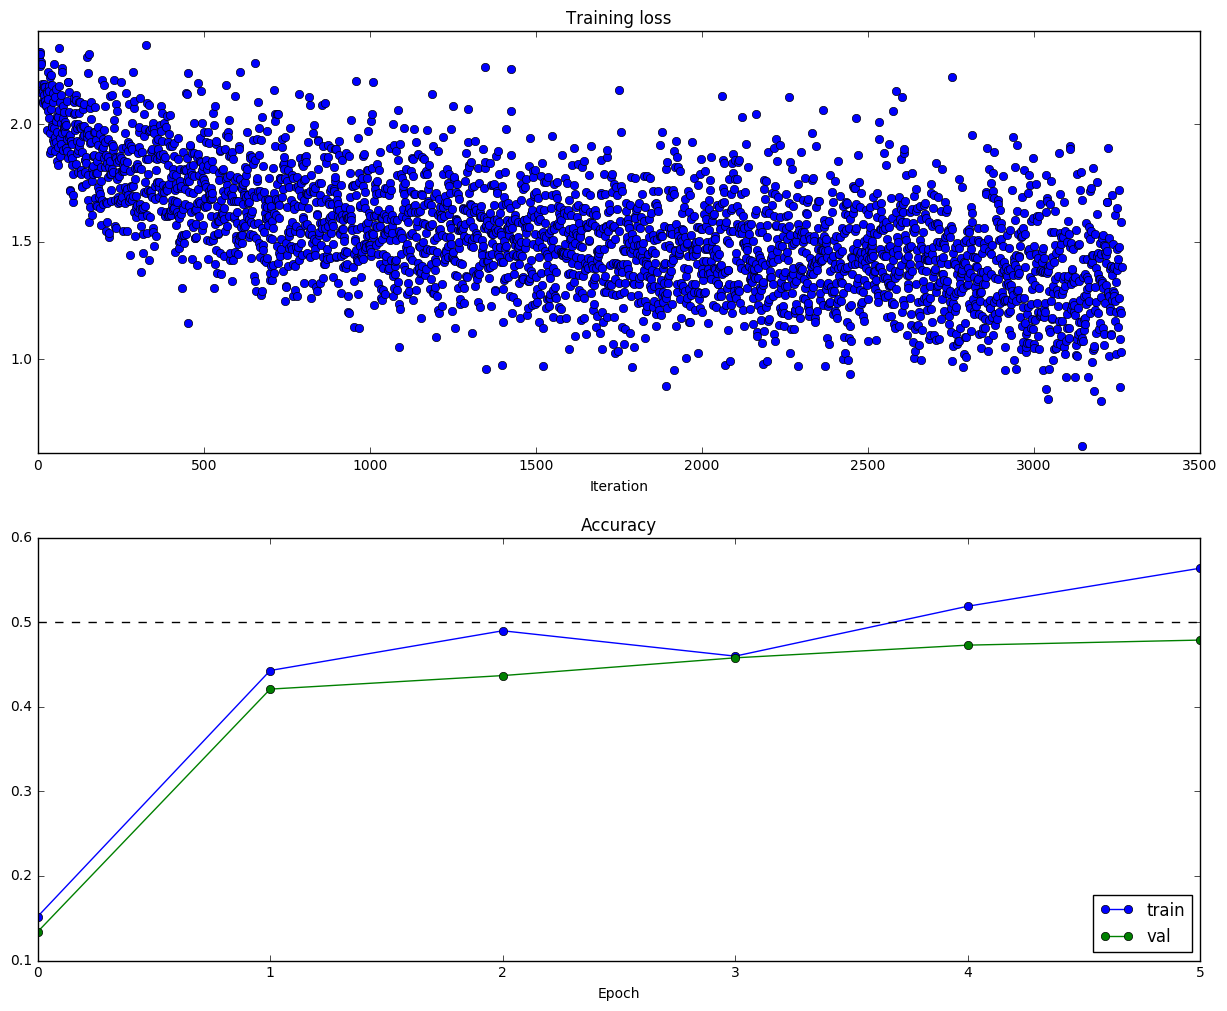

In [5]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver1.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver1.train_acc_history, '-o', label='train')
plt.plot(solver1.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Solver2

Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [6]:
best_model2 = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
# here I use the same parameters I got before, seems like they perform moderately fine
model2 = FullyConnectedNet([100, 100], weight_scale=0.0025, use_batchnorm = False, dropout = 0)
solver2 = Solver(model2, data1,
                        print_every=data1['X_train'].shape[0], num_epochs=5, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': 0.03,
                        },verbose=True, 
                 )
solver2.train()
best_model2 = model2
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 3265) loss: 2.300489
(Epoch 0 / 5) train acc: 0.137000; val_acc: 0.145000
(Epoch 1 / 5) train acc: 0.414000; val_acc: 0.410000
(Epoch 2 / 5) train acc: 0.468000; val_acc: 0.413000
(Epoch 3 / 5) train acc: 0.476000; val_acc: 0.452000
(Epoch 4 / 5) train acc: 0.519000; val_acc: 0.479000
(Epoch 5 / 5) train acc: 0.566000; val_acc: 0.484000


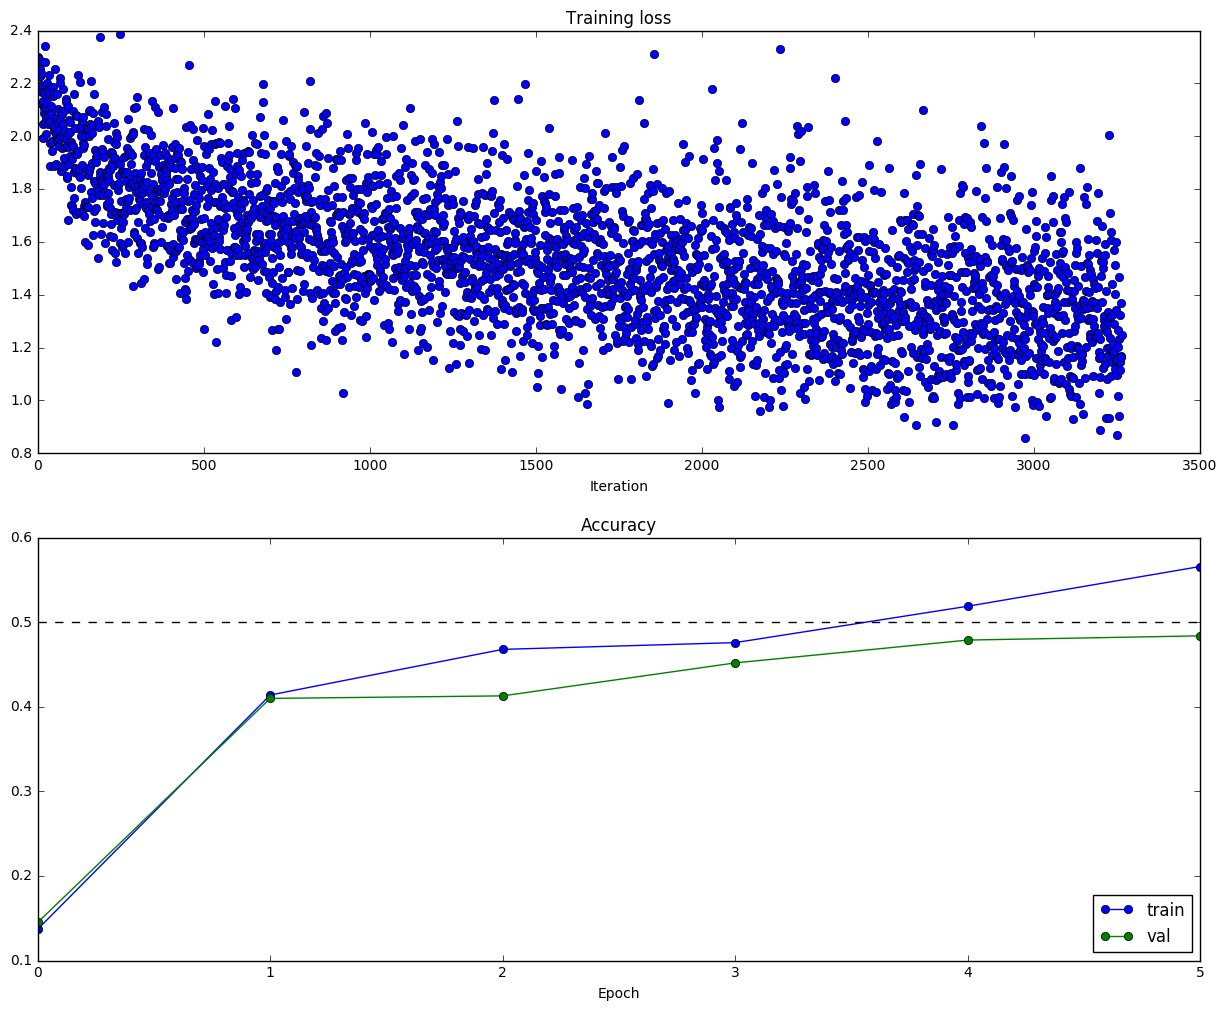

In [7]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver2.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver2.train_acc_history, '-o', label='train')
plt.plot(solver2.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Solver3

Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [34]:
best_model3 = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
# here I use the same parameters I got before, seems like they perform moderately fine
model3 = FullyConnectedNet([100, 100], weight_scale=0.0025, use_batchnorm = False, dropout = 0)
solver3 = Solver(model3, data3,
                        print_every=10, num_epochs=5, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': 0.0025,
                        },verbose=False, 
                 )
solver3.train()
best_model3 = model3
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

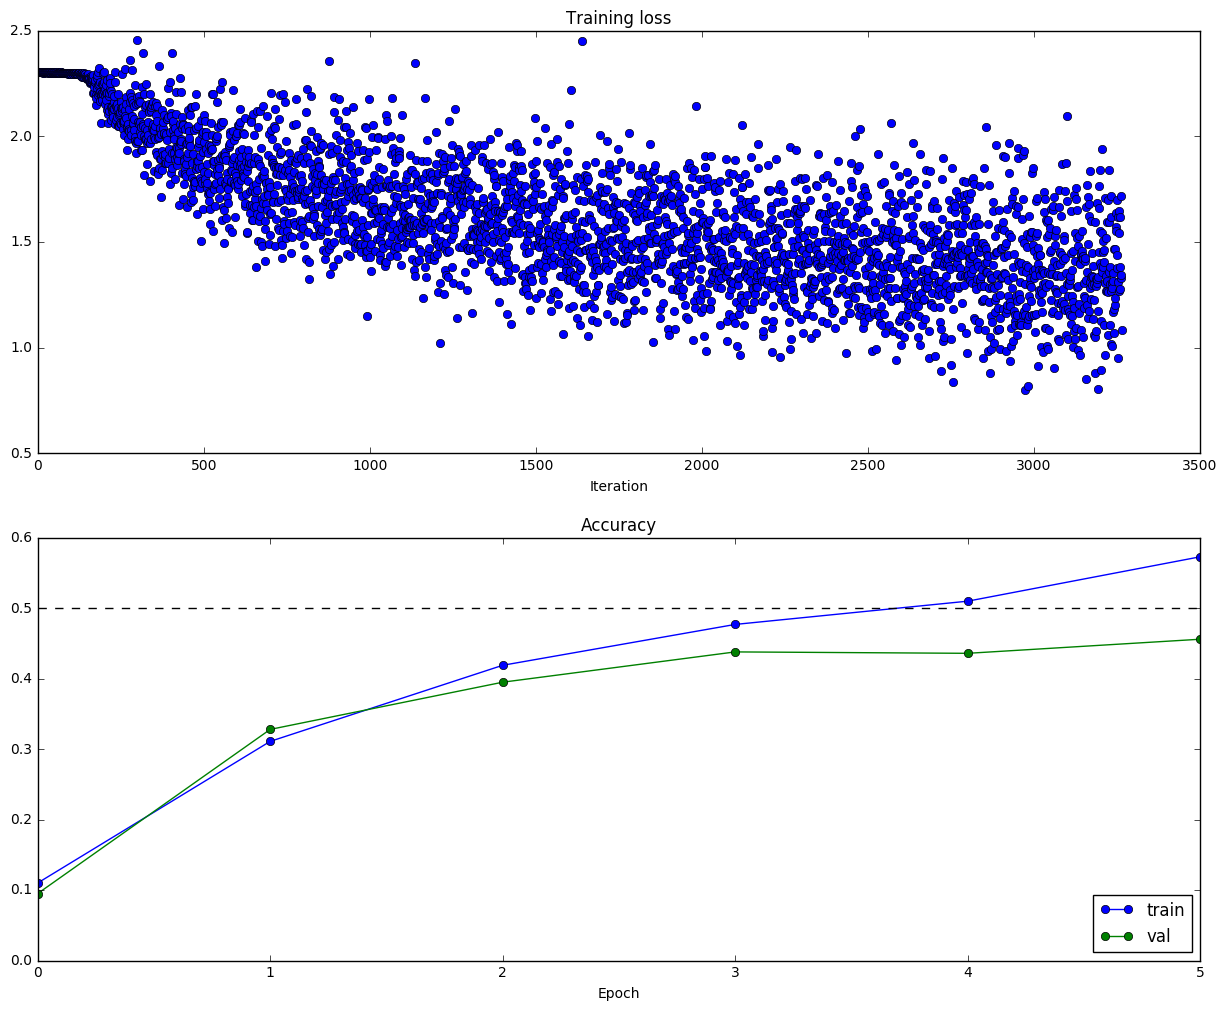

In [35]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver3.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver3.train_acc_history, '-o', label='train')
plt.plot(solver3.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver3.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

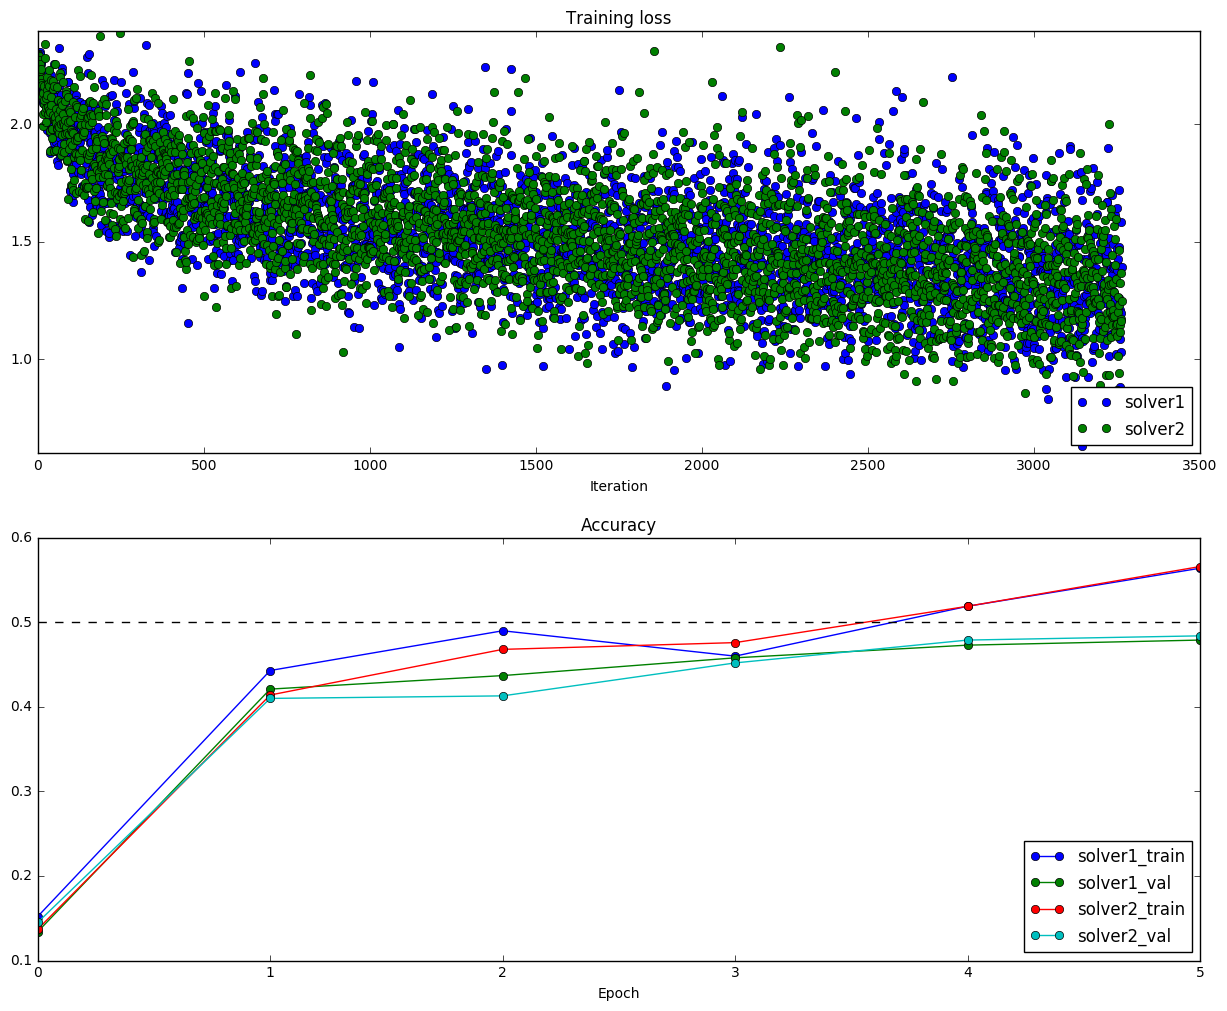

In [9]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver1.loss_history, 'o', label='solver1')
plt.plot(solver2.loss_history, 'o', label='solver2')
#plt.plot(solver3.loss_history, 'o', label='solver3')
plt.legend(loc='lower right')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver1.train_acc_history, '-o', label='solver1_train')
plt.plot(solver1.val_acc_history, '-o', label='solver1_val')
plt.plot(solver2.train_acc_history, '-o', label='solver2_train')
plt.plot(solver2.val_acc_history, '-o', label='solver2_val')
#plt.plot(solver3.train_acc_history, '-o', label='solver3_train')
#plt.plot(solver3.val_acc_history, '-o', label='solver3_val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig('Loss_accuracy_before_canonicalizaton.png', dpi=300)
plt.show()

# Rest

We have finally created three networks which sync with each other in similar fashion. The next step would be canonicalizing them

# Canonicalizing networks 2 and 3

In the following section we shall be canonicalizing two networks, so that they look as similar to network 1 as possible. This would make the ground work before we go ahead and show the combination of networks working in very similar fashion

In [37]:
from src.canonicalize import *
from src.required_funcs import *

model1p = deepcopy(model1)
model2p = deepcopy(model2)

indices = match_vals(model1p, model2p, method='Hungarian')
model2c = canon_nets(model2p, indices.astype(int), use_batchnorm = False)

In [39]:
from src.net_checker import *

check_fun(data2, model2, model2c, use_batchnorm=False)

Test accuracy after one swap:  14.3272705187
Test accuracy after two swaps:  12.0696440023
Test accuracy after final swaps:  9.41001260914


In [59]:
# test implementation on validation sets
y_val_pred = np.argmax(model2c.loss(data1['X_val']), axis=1)
res2 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res2

y_val_pred = np.argmax(model1.loss(data1['X_val']), axis=1)
res1 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res1

Validation set accuracy for new:  0.318
Validation set accuracy for new:  0.479


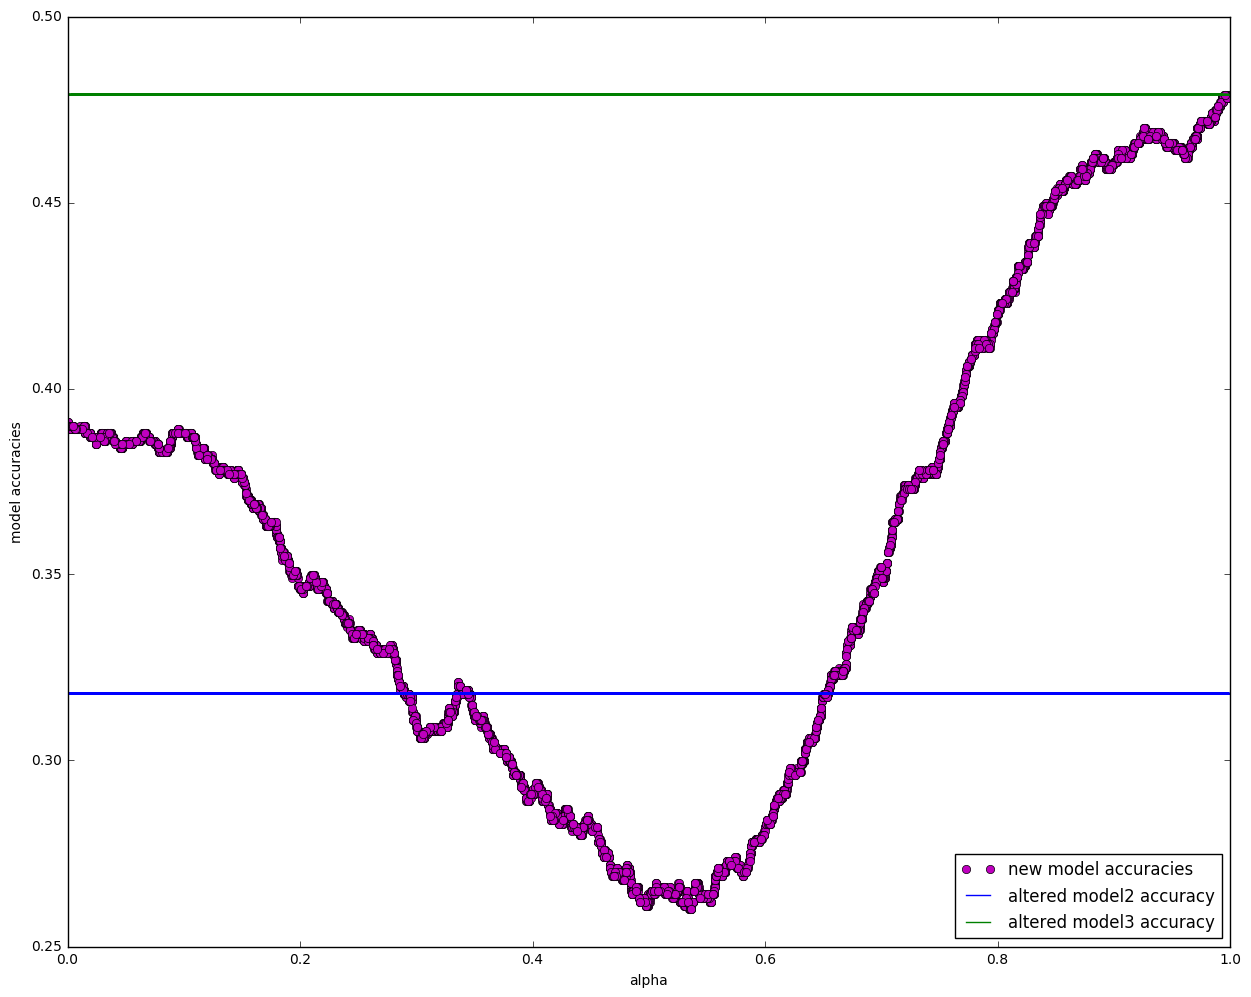

In [60]:
# once we have canonicalized two networks we choose \alpha as a real between zero and 1 and try to generate new networks
import random
from src.creator import *

alpha = np.zeros(100)
res = np.zeros(100)
res2 = np.ones(100)*res2
res1 = np.ones(100)*res1
for i in range(100):
    alpha[i] = random.random()
    new_model = create_model(model1, model2c, alpha[i])
    # test implementation on validation sets
    y_val_pred = np.argmax(new_model.loss(data1['X_val']), axis=1)
    res[i] = (y_val_pred == data1['y_val']).mean()
    
plt.plot(alpha, res, 'mo', label='new model accuracies')
plt.plot(alpha, res2, '-b', label='altered model2 accuracy')
plt.plot(alpha, res1, '-g', label='altered model3 accuracy')
plt.xlabel('alpha')
plt.ylabel('model accuracies')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig('New_model_accuracy_vs_alpha.png', dpi=300)
plt.show()

# Testing

Run the models on the test set

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()